# Small example of using the end-to-end network to predict neural acitivty from images

This is a small example of how to use the end-to-end network to predict neural acitivty from images. 

The model architecture matches the one used in the paper, but the dataset is a very small subset of a single session, and only serves the purpose to demonstrate how to train the model. This notebook runs in under 10 minutes on a single Nvidia RTX 1000 GPU.

The code that was used to train the end-to-end network for all of the full sessions on a GPU cluster can be found in the repository [BehaviorVideo](https://github.com/kurgyis/BehaviorVideo).



In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

import local_env
from VideoAnalysisUtils import end_to_end as e2e

#### Load example dataset
This dataset contains the neural activity of 10 neurons and cropped and resized side-view images belonging to 16 trials within a single session during ~0.9 seconds of the response period.

In [5]:
with open('../data/example_e2e_data_response.pickle', 'rb') as f:
    loaded_example_data = pickle.load(f)
print("Loaded example data:", loaded_example_data.keys())
print("Frames: (trial, timepoint, channel, height, width)", loaded_example_data['frames'].shape)
print("Firing rate: (trial, timepoint, channel)", loaded_example_data['fr'].shape)

Loaded example data: dict_keys(['frames', 'fr', 'trial_idx', 'trials', 'tt', 'go_times', 'start_time', 'end_time', 'dt'])
Frames: (trial, timepoint, channel, height, width) torch.Size([16, 256, 1, 120, 112])
Firing rate: (trial, timepoint, channel) torch.Size([16, 256, 10])


#### Set up the model and dataloader

In [6]:
mini_configs = {
    # input & CNN architecture
    'in_channels'      : 1,             # matches first Conv2d(1,16)
    'cnn_channels'     : [16, 32, 32],  # matches your three ResNet out_chan values
    'kernel_preconv'   : 1,             # ks1=1 in conv0 projections
    'kernel_residual'  : 3,             # ks2=3 in residual convolutions
    'residual_depth'   : 3,             # res_depth=3 layers per ResNet block
    'pool_size'        : 4,             # each MaxPool2d(kernel_size=4)
    'use_batch_norm'   : True,          # your printed model shows BatchNorm2d

    # temporal stacking & final head
    'neighbor_frames'  : 5,    # FF-nbr → 32*5 = 160 features into the linear
    'num_emit'         : 10,  # FF-num_emit → Linear(out_features=143)

    # actual input spatial dimensions
    'image_shape'      : (120, 112),  # height, width
    }

training_config = {
    'batch_size': 4,
    'sequence_length': 128,
    'num_epochs': 100,
    'lr': 1e-3,
}

In [7]:
model = e2e.Frame2FrEncoder(mini_configs)
optimizer = torch.optim.Adam(model.parameters(), lr= training_config['lr'])

In [8]:
mini_dataset = e2e.MiniFrameDataset(loaded_example_data, sequence_length= training_config['sequence_length'], center_fr=True, center_frames=True)
mini_dataloader = e2e.DataLoader(mini_dataset, batch_size=training_config['batch_size'], num_workers=1, shuffle=True)

If cuda is available the model will be moved to the GPU, otherwise it will run on the CPU.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)

Using device: cuda


Frame2FrEncoder(
  (cnn): Sequential(
    (0): ResidualBlock2D(
      (projection): Sequential(
        (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (residual): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MaxPool2d(kernel_size=4, str

In [10]:
train_loss = []

for epoch in range(training_config['num_epochs']):
    model.train()
    for i, (batch, batch_fr, trial_idx, sequence_idx) in enumerate(mini_dataloader):
        optimizer.zero_grad()
        output = model(batch.to(device))
        loss = torch.mean((output- batch_fr[:,2:-2].to(device))**2)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        
    print(f"Epoch {epoch} completed.")
    print(f"Final loss after epoch {epoch}: {loss.item():.4f}")

Epoch 0 completed.
Final loss after epoch 0: 1.4495
Epoch 1 completed.
Final loss after epoch 1: 1.2669
Epoch 2 completed.
Final loss after epoch 2: 1.1093
Epoch 3 completed.
Final loss after epoch 3: 1.1602
Epoch 4 completed.
Final loss after epoch 4: 1.0263
Epoch 5 completed.
Final loss after epoch 5: 1.1952
Epoch 6 completed.
Final loss after epoch 6: 1.0588
Epoch 7 completed.
Final loss after epoch 7: 0.8631
Epoch 8 completed.
Final loss after epoch 8: 0.9186
Epoch 9 completed.
Final loss after epoch 9: 0.9002
Epoch 10 completed.
Final loss after epoch 10: 0.7849
Epoch 11 completed.
Final loss after epoch 11: 0.9188
Epoch 12 completed.
Final loss after epoch 12: 0.7983
Epoch 13 completed.
Final loss after epoch 13: 0.8424
Epoch 14 completed.
Final loss after epoch 14: 0.7501
Epoch 15 completed.
Final loss after epoch 15: 0.8210
Epoch 16 completed.
Final loss after epoch 16: 0.8298
Epoch 17 completed.
Final loss after epoch 17: 0.6648
Epoch 18 completed.
Final loss after epoch 18: 0

Text(0.5, 1.0, 'Training Loss Over Time')

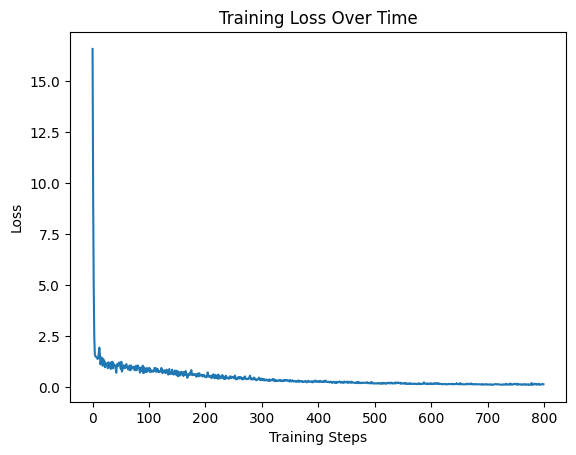

In [11]:
plt.plot(train_loss)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')

In [12]:
# since the sequence length is 128 and we use neighboring 5 frames to predict
# the firing rate and we do not pad the edges, we will not have predictions
# for the two timepoints at the beginning and end of each sequence.

full_fr_data = np.zeros((16,256-4*256//mini_dataset.sequence_length,10))
full_output = np.zeros((16,256-4*256//mini_dataset.sequence_length,10))
trial_ids = []
sequence_ids = []

eff_seq_len = mini_dataset.sequence_length - 4

with torch.no_grad():
    for batch, batch_fr, trial_idx, sequence_idx in mini_dataloader:
        output = model(batch.to(device))
        for ii,s_ii in enumerate(sequence_idx):
            full_fr_data[trial_idx[ii], s_ii*eff_seq_len:(s_ii+1)*eff_seq_len] = batch_fr[ii,2:-2].cpu()*mini_dataset.fr_std[None,:] + mini_dataset.fr_mean[None,:]
            full_output[trial_idx[ii], s_ii*eff_seq_len:(s_ii+1)*eff_seq_len] = output[ii].cpu()*mini_dataset.fr_std[None,:] + mini_dataset.fr_std[None,:]
        trial_ids.append(trial_idx.cpu())
        sequence_ids.append(sequence_idx.cpu())


/tmp/ipykernel_64499/1867739869.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  full_fr_data[trial_idx[ii], s_ii*eff_seq_len:(s_ii+1)*eff_seq_len] = batch_fr[ii,2:-2].cpu()*mini_dataset.fr_std[None,:] + mini_dataset.fr_mean[None,:]
/tmp/ipykernel_64499/1867739869.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  full_output[trial_idx[ii], s_ii*eff_seq_len:(s_ii+1)*eff_seq_len] = output[ii].cpu()*mini_dataset.fr_std[None,:] + mini_dataset.fr_std[None,:]


#### Example firing rates of a single neuron on all trials

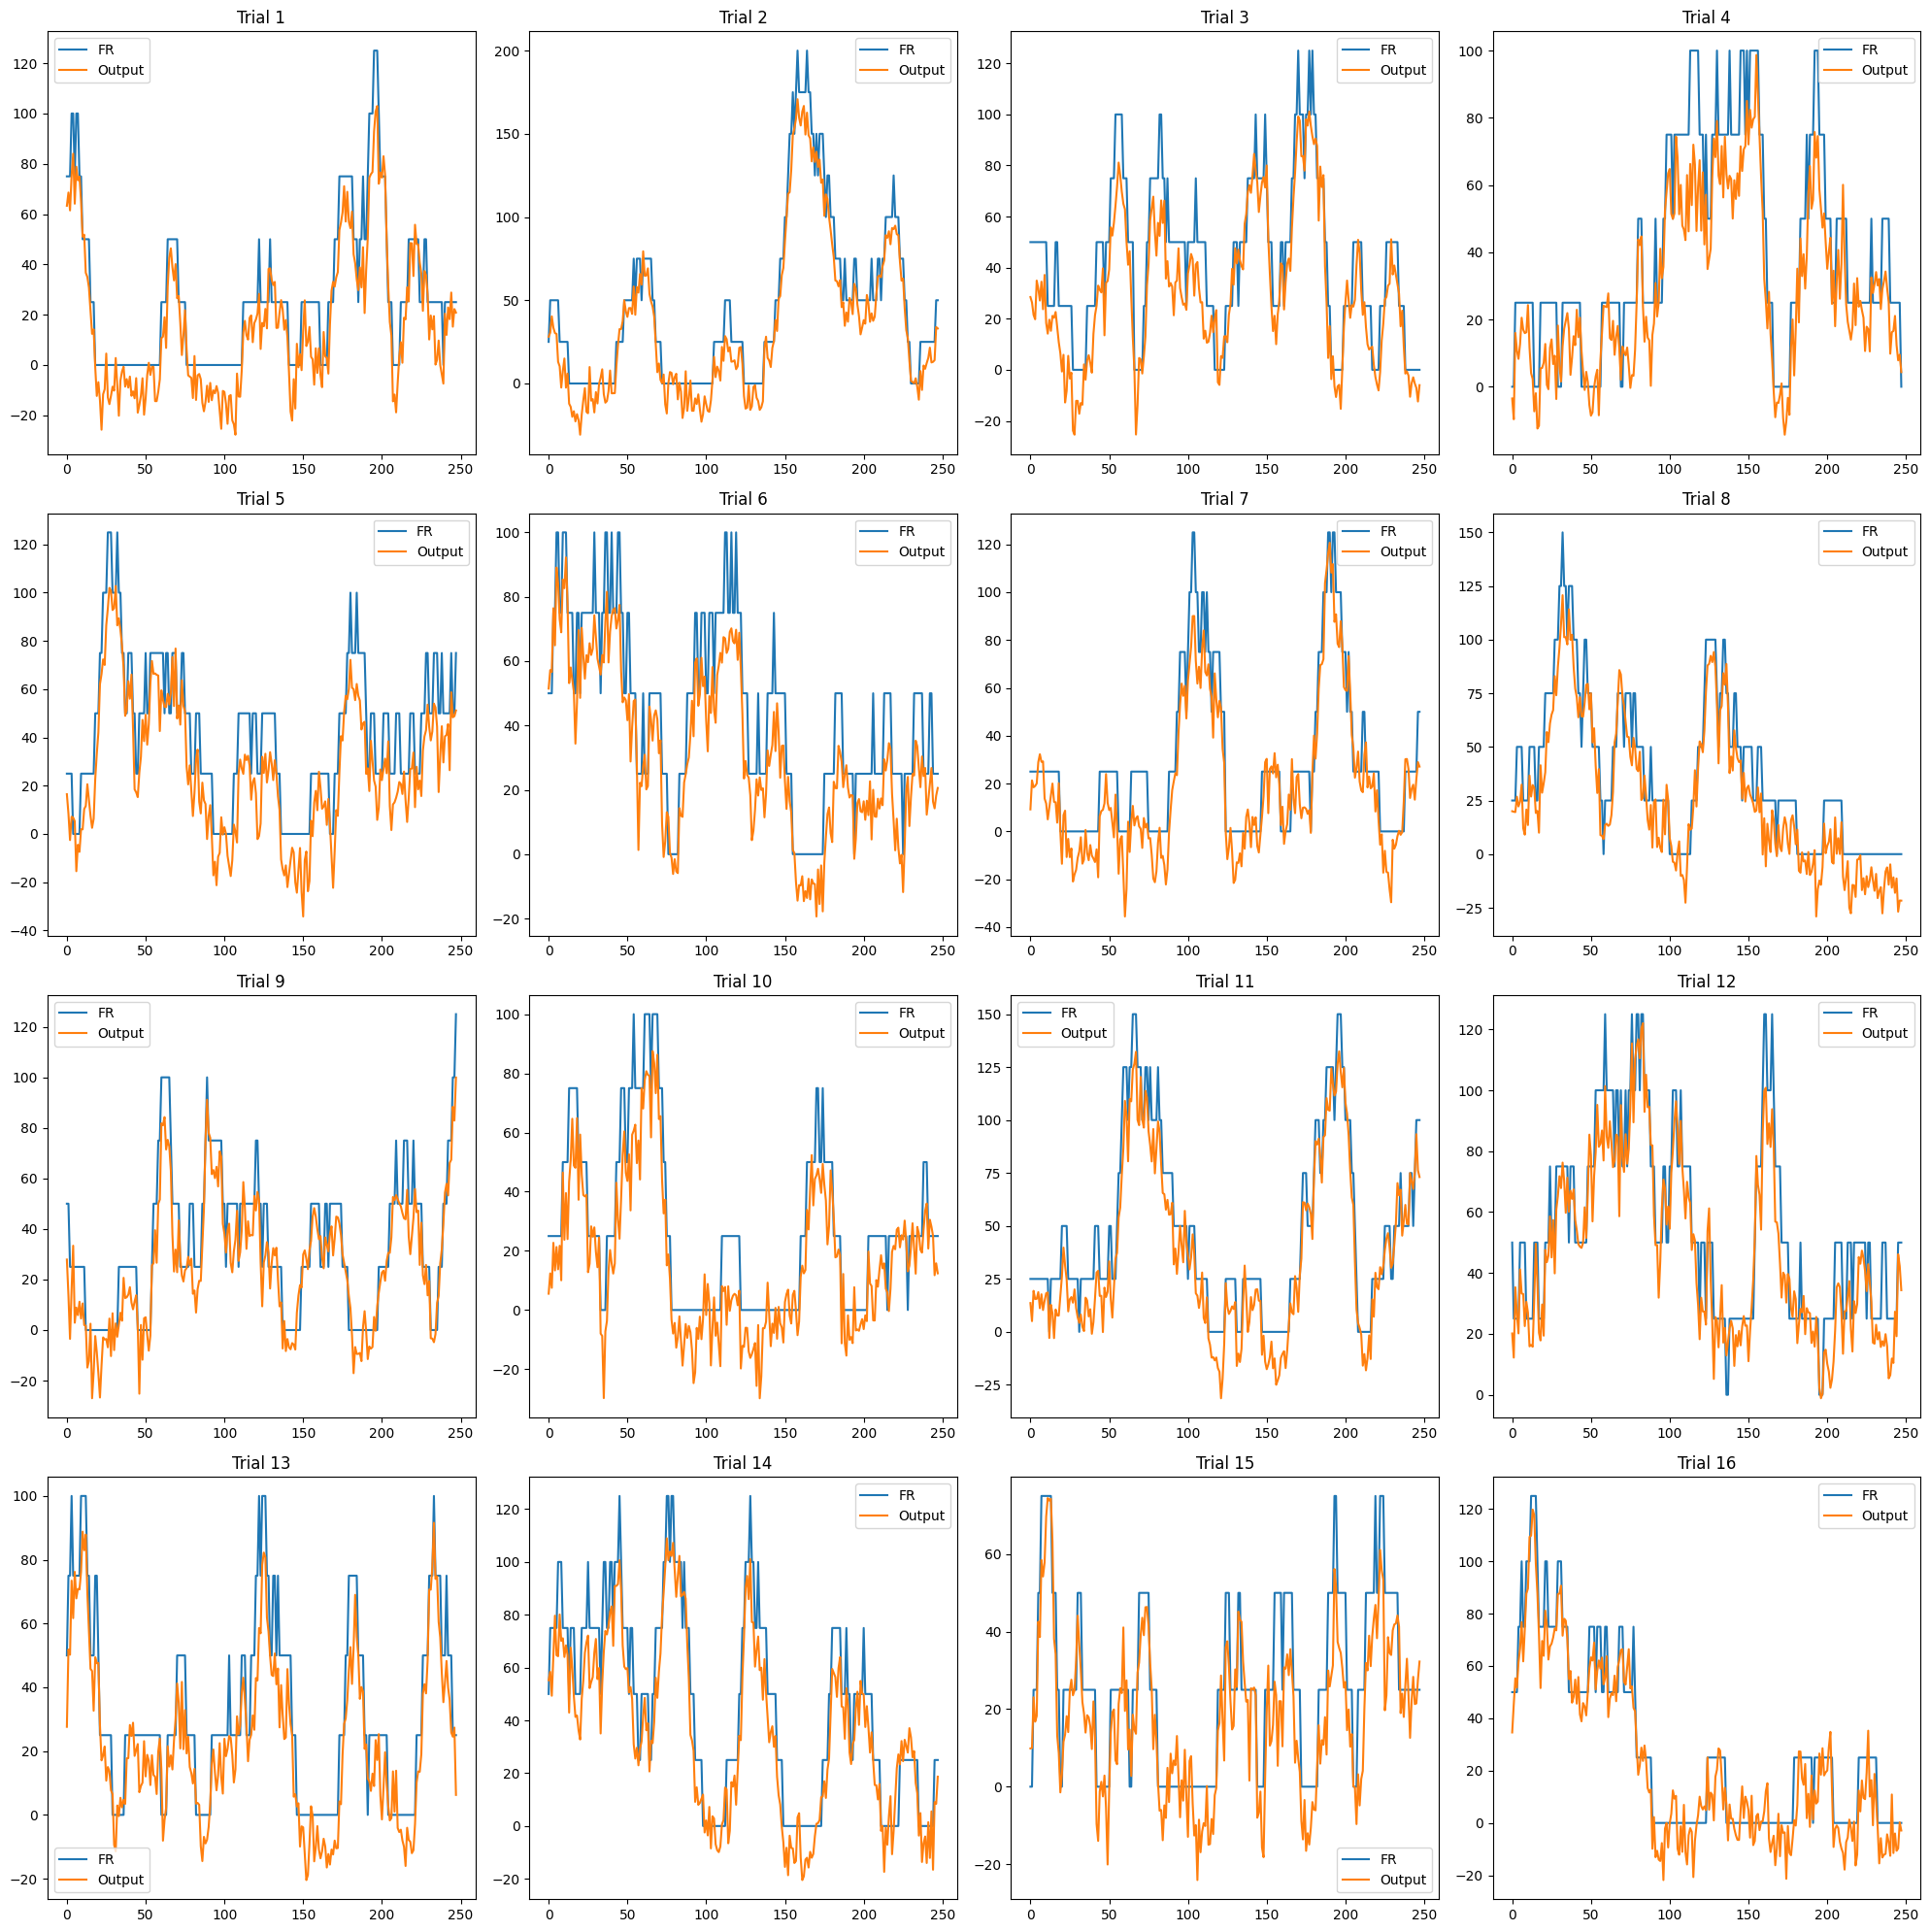

In [13]:
f, axs = plt.subplots(4, 4, figsize=(20, 20))
for i in range(16):
    ax = axs[i // 4, i % 4]
    ax.plot(full_fr_data[i,:,6], label='FR')
    ax.plot(full_output[i,:,6], label='Output')
    ax.set_title(f"Trial {i+1}")
    ax.legend()
plt.tight_layout()

#### Example predictions for all neurons on a single trial

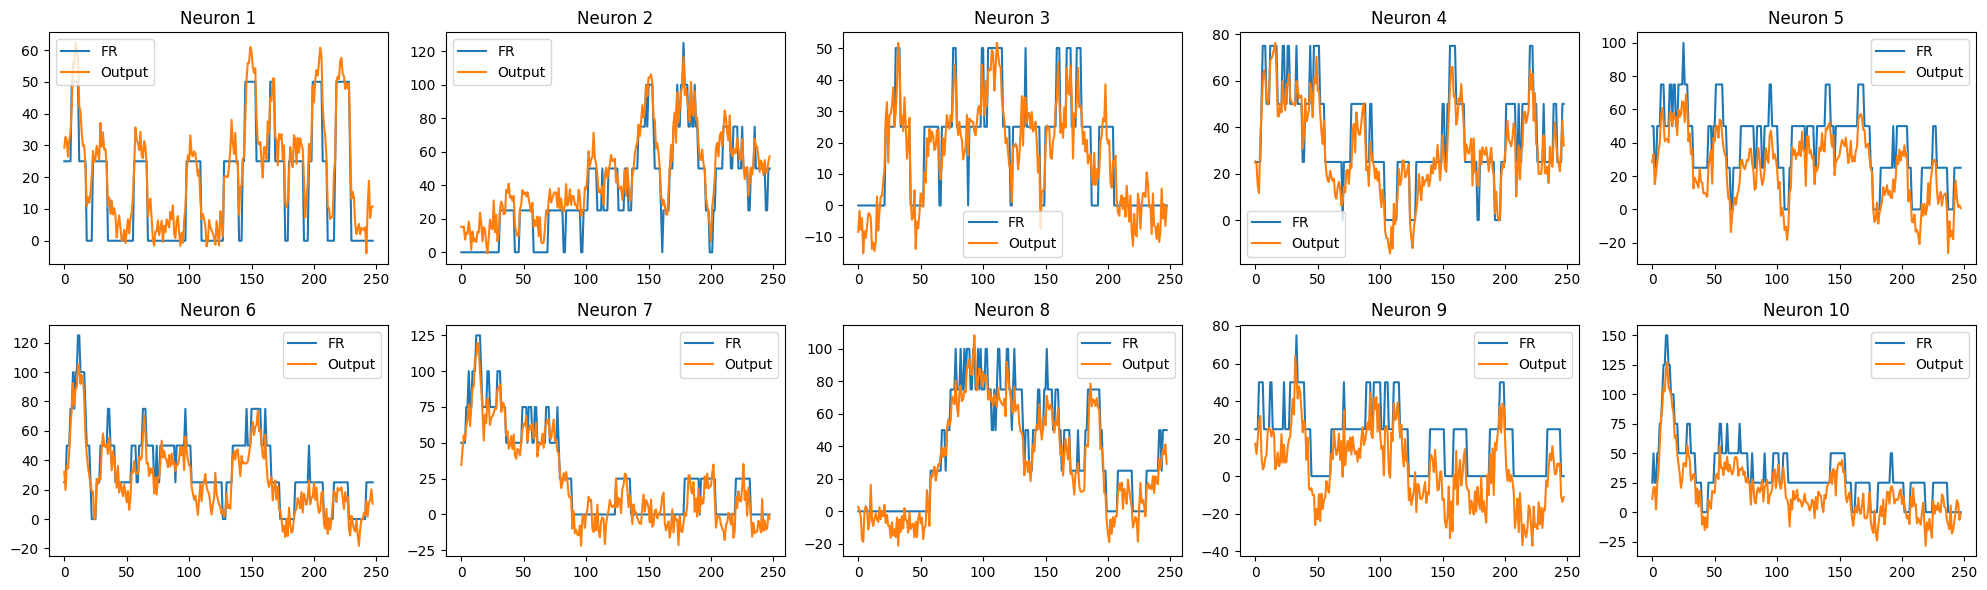

In [14]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
axs = axs.flatten()
for i in range(10):
    ax = axs[i]
    ax.plot(full_fr_data[-1,:,i], label='FR')
    ax.plot(full_output[-1,:,i], label='Output')
    ax.set_title(f"Neuron {i+1}")
    ax.legend()
plt.tight_layout()


#### Remarks

We do not use train-test splitting in this example as the example dataset is too small. To train the model on a full session takes about a day on a single GPU. For the full dataset, we used a single, random, balanced (left/right and correct/error) train-test split with fixed test size of 64 trials for all sessions.